In [1]:
import datetime as datetime
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt

#Permite ver los graficos sin colocar plt.show
%matplotlib inline 

plt.style.use('default')
#plt.rcParams['figure.figsize'] = (15, 5)


#Funcion para calcular distancias entre coordenadas (lat, lon)
from math import sin,cos,sqrt,asin,pi

#Formula del Harvesine sacada de
#https://joseguerreroa.wordpress.com/2012/11/13/distancia-entre-dos-puntos-de-la-superficie-terrestre-mediante-la-formula-de-haversine-con-python/
#coord = (lat, long)
def distancia(coord1, coord2):
    rTierra = 6374000 #metros
    c = pi/180 #para pasar a raddianes
    d = 2*rTierra*asin(sqrt(sin(c*(coord2[0]-coord1[0])/2)**2 + cos(c*coord1[0])*cos(c*coord2[0])*sin(c*(coord2[1]-coord1[1])/2)**2))
    return d

#reg = created_on, place_name, lat, lon, price_usd_per_m2
def distanciaANuevasEstaciones(reg):
    created_on, place_name, lat, lon, price_usd_per_m2 = reg
    geoPos = lat, lon
    #Ubicacion de las estaciones
    Cordoba = (-34.598691, -58.403841) #Inicio Obras: 17 ene 2012 - Inauguracion: 18 dic 2015
    SantaFe = (-34.594848, -58.402517) #Inicio Obras: 17 ene 2012 - Inauguracion: 12 jul 2016
    LasHeras = (-34.587879, -58.397970) #Inicio Obras: 17 ene 2012 - Inauguracion: 18 dic 2015

    distACordoba = distancia(geoPos, Cordoba)
    distASantaFe = distancia(geoPos, SantaFe)
    distALasHeras = distancia(geoPos, LasHeras)
    

    return min(distACordoba, distASantaFe, distALasHeras)

data17 = pd.read_csv("properati-AR-2017-08-01-properties-sell.csv", low_memory = False)
data16 = pd.read_csv("properati-AR-2016-12-01-properties-sell.csv", low_memory = False)
data15 = pd.read_csv("properati-AR-2015-12-01-properties-sell.csv", low_memory = False)
data14 = pd.read_csv("properati-AR-2015-12-01-properties-sell.csv", low_memory = False)
frames = [data14, data15, data16, data17]
data = pd.concat(frames)
data.head()

,country_name,created_on,currency,description,expenses,extra,floor,geonames_id,id,image_thumbnail,...,price_aprox_usd,price_per_m2,price_usd_per_m2,properati_url,property_type,rooms,state_name,surface_covered_in_m2,surface_total_in_m2,title
0,NaN,2012-08-08,NaN,Excelente depto. en planta alta con patio y co...,NaN,"{""images"":[""http://www.amaira.com.ar/buscador/...",NaN,3433778.0,NaN,http://thumbs3.properati.com/2/hrxzmGbOVe0AAWf...,...,NaN,NaN,NaN,http://general-san-martin-bs-as-g-b-a-zona-nor...,apartment,3.0,NaN,NaN,NaN,DEPARTAMENTO EN VENTA
1,NaN,2012-08-08,NaN,Venta chalet 4 ambientes en Villa Ballester e...,NaN,"{""images"":[""http://www.amaira.com.ar/buscador/...",NaN,3427467.0,NaN,http://thumbs3.properati.com/5/a4W8KzDBTc_SzTL...,...,NaN,NaN,NaN,http://villa-ballester.properati.com.ar/be_ven...,house,5.0,NaN,480.0,480.0,CASA EN VENTA
2,NaN,2012-09-19,USD,CASA CON LOCAL EN VENTA EN PADUA. 2 DORMITORI...,NaN,"{""images"":[""http://www.amaira.com.ar/buscador/...",NaN,3429244.0,NaN,http://thumbs3.properati.com/3/4WSbwKA0arL7bbQ...,...,120000.0,1290.322581,360.36036,http://san-antonio-de-padua.properati.com.ar/u...,house,NaN,NaN,93.0,333.0,CASA EN VENTA
3,NaN,2012-10-10,USD,"2 AMBIENTES, VENTA, VILLA CRESPO CON RENTA....",50,"{""apto_profesional"":true,""images"":[""http://www...",1.0,3427458.0,NaN,http://thumbs3.properati.com/4/hqn-p5RqpJu7eVj...,...,76500.0,1912.500000,1912.50000,http://villa-crespo.properati.com.ar/13tz_vent...,apartment,2.0,NaN,40.0,40.0,DEPARTAMENTO EN VENTA
4,NaN,2012-10-10,USD,"CASA, VENTA, VILLA CRESPO ""EXCELENTE CASA E...",NaN,"{""baulera"":true,""dependencia"":true,""apto_profe...",NaN,3430234.0,NaN,http://thumbs3.properati.com/6/szVEIqerNvrkp-o...,...,570000.0,1727.272727,1425.00000,http://palermo.properati.com.ar/13v3_venta_dep...,apartment,5.0,NaN,330.0,400.0,DEPARTAMENTO EN VENTA


In [10]:
data.drop_duplicates(subset=['lat', 'lon', 'price_usd_per_m2'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 493527 entries, 0 to 187481
Data columns (total 28 columns):
country_name                  245641 non-null object
created_on                    493527 non-null object
currency                      410945 non-null object
description                   493510 non-null object
expenses                      33353 non-null object
extra                         247886 non-null object
floor                         56681 non-null float64
geonames_id                   419545 non-null float64
id                            245641 non-null object
image_thumbnail               486477 non-null object
lat                           371658 non-null float64
lat-lon                       371658 non-null object
lon                           371652 non-null float64
operation                     493527 non-null object
place_name                    493463 non-null object
place_with_parent_names       493527 non-null object
price                         413289 no

In [2]:
#Solo me quedo con CAP FED y GBA
dataCapGba = data.loc[(data.state_name.str.contains('Capital Federal') | data.state_name.str.contains('G.B.A') ), ['created_on','operation', 'property_type', 'state_name', 'place_name', 'lat', 'lon', 'price', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor', 'rooms', 'expenses', 'description']]

In [29]:
dataCapGbaMenoresA10K = dataCapGba.loc[dataCapGba['price_usd_per_m2'] < 9000,:]
dataCapGbamayoresA1000 = dataCapGbaMenoresA10K.loc[dataCapGbaMenoresA10K['price_usd_per_m2'] > 1000,:]
dataCapGbamayoresA1000.sort_values('price_usd_per_m2', ascending = False)

,created_on,operation,property_type,state_name,place_name,lat,lon,price,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,description
11960,2016-08-20,sell,store,Capital Federal,Villa Crespo,-34.593665,-58.435889,700000.0,78.0,78.0,8974.358974,8974.358974,NaN,NaN,NaN,VENTA - Excelente local comercial en Esquina e...
39820,2016-08-20,sell,store,Capital Federal,Villa Crespo,-34.593665,-58.435889,700000.0,78.0,78.0,8974.358974,8974.358974,NaN,NaN,NaN,VENTA - Excelente local comercial en Esquina e...
54729,2016-12-01,sell,store,Capital Federal,Villa Crespo,-34.603771,-58.381587,1300000.0,145.0,145.0,8965.517241,8965.517241,NaN,NaN,NaN,Unico Local Comercial Con renta. Valor Locativ...
32576,2016-12-01,sell,store,Capital Federal,Villa Crespo,-34.603771,-58.381587,1300000.0,145.0,145.0,8965.517241,8965.517241,NaN,NaN,NaN,Unico Local Comercial Con renta. Valor Locativ...
33016,2016-06-24,sell,apartment,Bs.As. G.B.A. Zona Norte,Tigre,NaN,NaN,107400.0,12.0,66.0,8950.000000,1627.272727,2.0,NaN,NaN,La mejor ubicacion del paseo costanero de Tigr...
2948,2016-06-24,sell,apartment,Bs.As. G.B.A. Zona Norte,Tigre,NaN,NaN,107400.0,12.0,66.0,8950.000000,1627.272727,2.0,NaN,NaN,La mejor ubicacion del paseo costanero de Tigr...
77580,2017-03-14,sell,apartment,Capital Federal,Puerto Madero,-34.617719,-58.362056,1700000.0,190.0,141.0,8947.368421,12056.737589,NaN,4.0,NaN,CARACTERÍSTICAS DE LOS EDIFICIOS• 2 torres de ...
173269,2017-07-20,sell,house,Bs.As. G.B.A. Zona Norte,Nordelta,NaN,NaN,375000.0,42.0,205.0,8928.571429,1829.268293,NaN,NaN,NaN,Excelente casa en lote Perimet...
111565,2017-06-10,sell,apartment,Capital Federal,Puerto Madero,-34.617981,-58.362839,2450000.0,275.0,188.0,8909.090909,13031.914894,NaN,5.0,NaN,"Exclusivo departamento de 247mts Totales, ubic..."
172694,2017-07-19,sell,apartment,Capital Federal,Puerto Madero,NaN,NaN,365030.0,41.0,NaN,8903.170732,NaN,NaN,NaN,NaN,Suite 404PRECIOS DESDE: -Suite Hotel: 36.9m2 U...


In [30]:
dataCapGbaSupmayor5 = dataCapGbamayoresA1000.loc[dataCapGbamayoresA1000['surface_total_in_m2'] > 5, :]
dataCapGbaSupmayor5.loc[:, "year"] = dataCapGbaSupmayor5.apply(lambda x: x["created_on"].partition("-")[0], axis = 1)

## Veamos el precio del m2 en recoleta por año

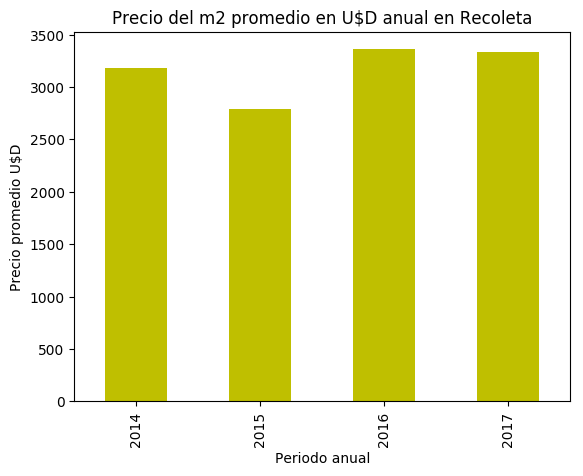

In [14]:
propiedadesEnRecoleta = dataCapGbaSupmayor5.dropna(subset=['place_name'])
propiedadesEnRecoleta = propiedadesEnRecoleta.loc[propiedadesEnRecoleta.place_name.str.contains('Recoleta'), ['created_on', 'price_usd_per_m2', 'property_type', 'year']]
propiedadesEnRecoleta.loc[:, "yearmonth"] = propiedadesEnRecoleta.apply(lambda x: x["created_on"].partition("-")[0] + "-" + (x["created_on"].partition("-")[2]).partition("-")[0], axis = 1)
recoletaPorMes = propiedadesEnRecoleta.groupby('year').agg([np.size, np.mean])
recoletaPorMes = recoletaPorMes.loc[recoletaPorMes['price_usd_per_m2']['size'] > 5.0, :]
graficoRecoleta = recoletaPorMes['price_usd_per_m2']['mean'].plot(kind ='bar', color='y', legend=False, title="Precio del m2 promedio en U$D anual en Recoleta")
graficoRecoleta.set_xlabel("Periodo anual")
graficoRecoleta.set_ylabel("Precio promedio U$D")

# Se puede ver una suba de precios de 2015 a 2016. Esto puede ser por la cercania de las propiedades a las nuevas estaciones del subte H. Veamoslo

## Precio por m2 en relacion a la cercania al Subte H y al año de su inauguracion
### Tomando propiedades con distancia 400mts

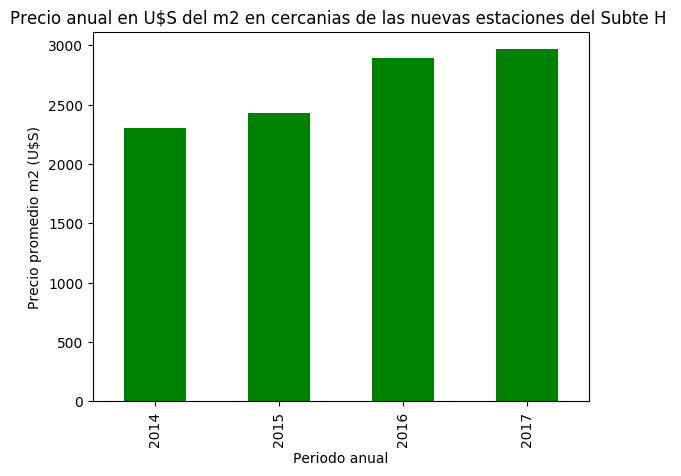

In [15]:
cercanasANuevasEstaciones = dataCapGbaSupmayor5.loc[dataCapGbaSupmayor5.lat.notnull() & dataCapGbaSupmayor5.lon.notnull(), ['year', 'place_name', 'lat', 'lon', 'price_usd_per_m2']]
cercanasANuevasEstaciones.loc[:, 'distanciaAEstacion'] = cercanasANuevasEstaciones.apply(distanciaANuevasEstaciones, axis = 1)
#Solo dejo las propiedades que estan a menos de 400mts
cercanasANuevasEstaciones = cercanasANuevasEstaciones.loc[cercanasANuevasEstaciones["distanciaAEstacion"] < 400, :]

cercanasGrafico = cercanasANuevasEstaciones.drop('lat', axis=1).drop('lon', axis=1).drop('place_name', axis=1).drop('distanciaAEstacion', axis=1)
grafico1 = cercanasGrafico.groupby('year').agg(np.mean).plot(kind ='bar', color='g', legend=False, title="Precio anual en U$S del m2 en cercanias de las nuevas estaciones del Subte H ")
grafico1.set_xlabel("Periodo anual")
grafico1.set_ylabel("Precio promedio m2 (U$S)")

# Viendo que pasa en Villa Urquiza en los ultimos 2 años

c:\python27\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


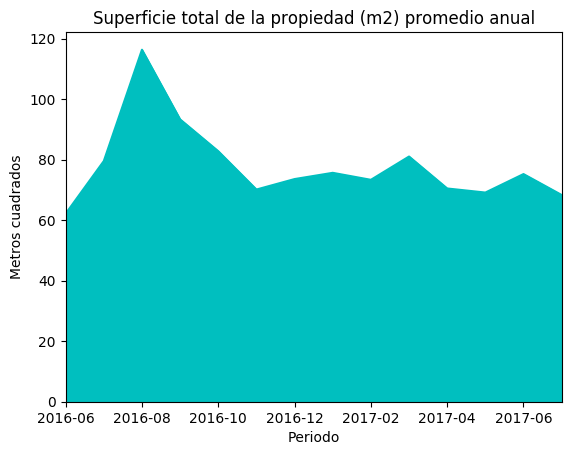

In [16]:
propVillaUrquiza = dataCapGbaSupmayor5.dropna(subset=['place_name'])
propVillaUrquiza.loc[:, "yearmonth"] = propVillaUrquiza.apply(lambda x: x["created_on"].partition("-")[0] + "-" + (x["created_on"].partition("-")[2]).partition("-")[0], axis = 1)
propVillaUrquiza20172016 = propVillaUrquiza.loc[propVillaUrquiza.place_name.str.contains('Villa Urquiza') & (propVillaUrquiza.yearmonth.str.contains('2017') | propVillaUrquiza.yearmonth.str.contains('2016')), ['yearmonth', 'property_type', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2']]
#Filtro los que tengan pocos registros (menos de 15)
propVillaUrquiza20172016.loc[: ,'cant'] = 1

#Agrego columna: porcentaje cubierto y tomo las que tienen menor o igual cubierta que total
#propVillaUrquiza20172016.loc[propVillaUrquiza20172016['surface_covered_in_m2']/propVillaUrquiza20172016['surface_total_in_m2'] <= 1.0, 'sup_percentage_covered'] = propVillaUrquiza20172016['surface_covered_in_m2']/propVillaUrquiza20172016['surface_total_in_m2']

propVillaUrquiza20172016grouped = propVillaUrquiza20172016.groupby('yearmonth').agg([np.size, np.mean])
#Solo tomo los que tengan mas de 10 casas
propVillaUrquiza20172016grouped = propVillaUrquiza20172016grouped.loc[propVillaUrquiza20172016grouped['cant']['size'] > 10, :]
propVillaUrquiza20172016grouped

#Superficie total de las publicaciones (fue bajando a lo largo de los ultimos meses)
propVillaUrquizaSupTotalPromedio = propVillaUrquiza20172016grouped.loc[:, ['yearmonth', 'surface_total_in_m2']]
dibujoVUm2 = propVillaUrquizaSupTotalPromedio['surface_total_in_m2']['mean'].plot(kind='area', color='c', title='Superficie total de la propiedad (m2) promedio anual')
dibujoVUm2.set_xlabel("Periodo")
dibujoVUm2.set_ylabel("Metros cuadrados")
#Porcentaje cubierto promedio
#propVillaUrquizaPorcentajeCubierto = propVillaUrquiza20172016.loc[:, ['yearmonth', 'sup_percentage_covered']]
#propVillaUrquizaPorcentajeCubierto

## Vemos que el promedio de la superficie cubierta para las propiedades publicadas fue bajando y esta causa puede ser la expansion del barrio, el cual crecio "para arriba", construyendose muchos edificios. Esto lo podemos comprobar facilmente:

In [17]:
propVillaUrquiza20172016['property_type'].value_counts()

apartment    1465
PH            110
house          62
store          27
Name: property_type, dtype: int64

#### Aca se ve como se vendieron muchos mas departamentos que otro tipo de propiedad durante estos ultimos dos años.

## Separando por zonas GBA Norte/Sur/Oeste y Capital Federal

In [18]:
publicaciones = dataCapGbaSupmayor5.loc[:, ['state_name', 'property_type', 'year', 'price_usd_per_m2']].groupby(['state_name', 'property_type', 'year']).count()
publicacionesCapFed = dataCapGbaSupmayor5.loc[dataCapGbaSupmayor5['state_name'].str.contains('Capital Federal'), ['property_type', 'year', 'price_usd_per_m2']].groupby(['property_type', 'year']).count()
publicacionesGBANorte = dataCapGbaSupmayor5.loc[dataCapGbaSupmayor5['state_name'].str.contains('Bs.As. G.B.A. Zona Norte'), ['property_type', 'year', 'price_usd_per_m2']].groupby(['property_type', 'year']).count()
publicacionesGBASur = dataCapGbaSupmayor5.loc[dataCapGbaSupmayor5['state_name'].str.contains('Bs.As. G.B.A. Zona Sur'), ['property_type', 'year', 'price_usd_per_m2']].groupby(['property_type', 'year']).count()
publicacionesGBAOeste = dataCapGbaSupmayor5.loc[dataCapGbaSupmayor5['state_name'].str.contains('Bs.As. G.B.A. Zona Oeste'), ['property_type', 'year', 'price_usd_per_m2']].groupby(['property_type', 'year']).count()

publicaciones
#publicaciones = publicaciones.rename(columns = {'price_usd_per_m2': 'Cantidad de publicaciones'})
#publicaciones.unstack(level=0).plot(kind='bar', subplots=True)

price_usd_per_m2
state_name               property_type year                  
Bs.As. G.B.A. Zona Norte PH            2013                 3
                                       2014                13
                                       2015                53
                                       2016               292
                                       2017               451
                         apartment     2013                19
                                       2014               102
                                       2015               688
                                       2016              6254
                                       2017              7481
                         house         2013                 7
                                       2014                53
                                       2015               392
                                       2016              4881
                                       2017              6154
                         store         2014                 6
                                       2015                47
                                       2016               247
                                       2017               261
Bs.As. G.B.A. Zona Oeste PH            2013                 5
                                       2014                43
                                       2015                97
                                       2016               391
                                       2017               287
                         apartment     2013                70
                                       2014               375
                                       2015               435
                                       2016              1673
                                       2017              1713
                         house         2013                23
...                                                       ...
Bs.As. G.B.A. Zona Sur   apartment     2016              1099
                                       2017              2888
                         house         2013                 2
                                       2014                19
                                       2015                26
                                       2016               688
                                       2017              1511
                         store         2014                 4
                                       2015                 6
                                       2016                60
                                       2017               155
Capital Federal          PH            2014                50
                                       2015                92
                                       2016               936
                                       2017              1178
                         apartment     2013                 7
                                       2014               405
                                       2015               693
                                       2016             13607
                                       2017             19766
                         house         2013                 4
                                       2014                30
                                       2015                84
                                       2016               936
                                       2017               911
                         store         2013                 1
                                       2014                50
                                       2015                52
                                       2016               757
                                       2017               835

[77 rows x 1 columns]

# Agrupando por barrio de CABA y año y tomando unicamente los que tengan mas de 10 publicaciones por año
### Tambien se elimina el barrio "Capital Federal" por no ser especifico

In [31]:
CABAPorBarrioYAnio = dataCapGbaSupmayor5.loc[dataCapGbaSupmayor5.state_name.str.contains('Capital Federal'), :]
#Agrego el campo "año"
CABAPorBarrioYAnio.loc[:, "year"] = CABAPorBarrioYAnio.apply(lambda x: x["created_on"].partition("-")[0], axis = 1)
#Elimino el barrio "Capital Federal"
CABAPorBarrioYAnio = CABAPorBarrioYAnio.loc[~CABAPorBarrioYAnio.place_name.str.contains('Capital Federal'), ["year", "place_name", "price_usd_per_m2"]]
CABAPorBarrioYAniog = CABAPorBarrioYAnio.groupby(["place_name", "year"]).agg([np.size, np.mean])
#Mas de 10 publicaciones por año
CABAPorBarrioYAnioGrouped = CABAPorBarrioYAniog.loc[CABAPorBarrioYAniog['price_usd_per_m2']['size'] > 10, :]
#Saco la columna de precio por metro cuadrado afuera creando una columna "diff" de mismo valor
CABAPorBarrioYAnioGrouped["diff"] = CABAPorBarrioYAnioGrouped['price_usd_per_m2']['mean']
#Borro "price_usd_per_m2" que tiene el mean() y el size()
CABAPorBarrioYAnioGrouped.drop(['price_usd_per_m2'], axis=1, inplace=True)
#Reemplazo el nombre de "diff" por "price_usd_per_m2"
CABAPorBarrioYAnioGrouped.columns = ['price_usd_per_m2']
CABAPorBarrioYAnioGrouped

c:\python27\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
c:\python27\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


price_usd_per_m2
place_name          year                  
Abasto              2016       2044.499113
                    2017       2119.452961
Agronomía           2016       2162.766473
                    2017       2139.282478
Almagro             2014       1801.717737
                    2015       2266.894082
                    2016       2113.773003
                    2017       2228.842669
Balvanera           2014       1776.271874
                    2015       1657.254069
                    2016       1843.080828
                    2017       1955.709567
Barracas            2015       1844.998535
                    2016       1856.342263
                    2017       1991.897913
Barrio Norte        2014       2308.834111
                    2015       2296.562086
                    2016       2872.548598
                    2017       3040.962998
Belgrano            2014       2740.470687
                    2015       2708.278120
                    2016       3210.504332
                    2017       3126.336773
Boca                2016       1553.117467
                    2017       1712.830470
Boedo               2015       1668.117070
                    2016       1763.820227
                    2017       2439.621500
Caballito           2015       2027.467179
                    2016       2354.410076
...                                    ...
Velez Sarsfield     2017       1735.604911
Versalles           2016       1712.840495
                    2017       1599.685371
Villa Crespo        2014       3376.053995
                    2015       2359.057062
                    2016       2466.350272
                    2017       2516.723186
Villa Devoto        2016       2157.017862
                    2017       2157.052897
Villa General Mitre 2016       1829.717064
                    2017       1886.599674
Villa Lugano        2016       1428.680156
                    2017       1458.199647
Villa Luro          2015       1902.771916
                    2016       1796.976453
                    2017       2077.737122
Villa Ortuzar       2016       2233.904577
                    2017       2358.035158
Villa Pueyrredón    2016       1870.531863
                    2017       2105.613744
Villa Real          2016       1834.161662
                    2017       1549.883948
Villa Santa Rita    2016       1818.126908
                    2017       1862.924460
Villa Urquiza       2014       1839.871215
                    2015       2211.276258
                    2016       2515.749901
                    2017       2474.828936
Villa del Parque    2016       1991.021354
                    2017       2282.759303

[157 rows x 1 columns]

In [32]:
#Creo un nuevo dataframe vacio con esta estructura
barriosPorCrecimiento = pd.DataFrame(columns=("place_name", "price_usd_per_m2"))

# Calculando el "crecimiento" del barrio en base al promedio del precio por metro cuadrado (USD) en los distintos años
## Se calculo el crecimiento siguiente metodo: 
## SUMATORIA cant años - 1(valorAño[i + 1]/valorAño[i]*100 - 100)
#### Ejemplo: Si tomamos el barrio "Almagro" => (2014, 1801.717737), (2015, 2266.894082), (2016, 2113.773003), (2017, 2228.842669)
#### Entonces, crecimientoTotal = [(2266.894082/1801.717737 * 100) - 100] + [(2113.773003/2266.894082 * 100) - 100] + [(2228.842669/2113.773003 * 100) - 100] = 25.81 + (-6.75) + 5.44 = 24.5
#### A valores mas altos, mayor crecimiento

In [59]:
cabaPorBarriosG = CABAPorBarrioYAnioGrouped.reset_index().groupby(["place_name"])
barrios = cabaPorBarriosG.groups.keys()
bIndex = 0
for x in barrios:
    grupo = cabaPorBarriosG.get_group(x)
    numDatos = grupo['price_usd_per_m2'].size
    #Tomo solo los barrios que tengan datos de 2 años o mas
    if numDatos > 1:
        keys = grupo['price_usd_per_m2'].keys()
        crecimiento = 0.0
        for i in range(0, numDatos - 1):
            crecimiento += (grupo['price_usd_per_m2'][keys[i + 1]]/grupo['price_usd_per_m2'][keys[i]])*100 - 100
                
        #print "El crecimiento de %s fue %f" % (x, crecimiento)
        barriosPorCrecimiento.loc[bIndex] = [x, crecimiento]
        bIndex += 1
        

barriosPorCrecimiento = barriosPorCrecimiento.sort_values('price_usd_per_m2', ascending=False)
barriosPorCrecimiento.head(5)

,place_name,price_usd_per_m2
6,Boedo,44.051831
26,Centro / Microcentro,40.216636
41,Retiro,37.807190
23,Villa Urquiza,32.329015
42,Nuñez,31.381317


In [35]:
#El barrio con mayor crecimiento del precio promedio por m2 a lo largo de los años fue Boedo. Si miramos sus valores:
CABAPorBarrioYAnioNoIndex = CABAPorBarrioYAnioGrouped.reset_index()
boedo = CABAPorBarrioYAnioNoIndex.loc[CABAPorBarrioYAnioNoIndex.place_name.str.contains("Boedo"), :]
boedo

,place_name,year,price_usd_per_m2
25,Boedo,2015,1668.117070
26,Boedo,2016,1763.820227
27,Boedo,2017,2439.621500


In [36]:
#Se ve un gran crecimiento del precio del metro cuadrado de 2016 a 2017. Veamos estos valores a lo largo de los meses
boedoEnMeses = dataCapGbaSupmayor5.dropna(subset=['created_on', 'place_name'])
boedoEnMeses = boedoEnMeses.loc[boedoEnMeses.place_name.str.contains("Boedo"), ["created_on", "price_usd_per_m2", "lat", "lon", "description"]]
boedoEnMeses.loc[:, "yearmonth"] = boedoEnMeses.apply(lambda x: x["created_on"].partition("-")[0] + "-" + (x["created_on"].partition("-")[2]).partition("-")[0], axis = 1)
boedoEnMeses = boedoEnMeses.loc[boedoEnMeses['yearmonth'] > '2016-08', :]
boedoEnMeses = boedoEnMeses.loc[boedoEnMeses['yearmonth'] < '2017-08', :]
boedoEnMesesGrouped = boedoEnMeses.loc[:, ["yearmonth", "price_usd_per_m2"]].groupby('yearmonth').agg([np.mean, np.size])
boedoEnMesesGrouped = boedoEnMesesGrouped.loc[boedoEnMesesGrouped['price_usd_per_m2']['size'] > 5, :]
boedoEnMesesGrouped

price_usd_per_m2       
                      mean   size
yearmonth                        
2016-09        1927.270502   38.0
2016-10        1536.911680   46.0
2016-11        1791.912123   65.0
2016-12        1857.741890   39.0
2017-01        1780.043479   11.0
2017-02        1563.652848   11.0
2017-03        1706.491446   18.0
2017-04        2810.557721  237.0
2017-05        1874.124140   18.0
2017-06        2022.264827   23.0
2017-07        2067.526488  102.0

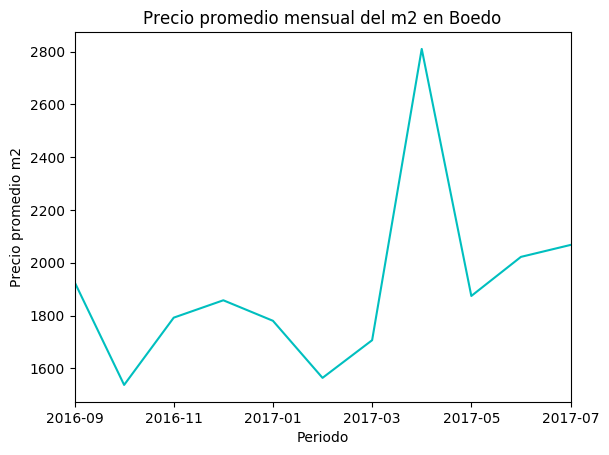

In [37]:
#El promedio del precio por m2 se dispara a 2800USD en Abril de 2017
grafBoedo = boedoEnMesesGrouped['price_usd_per_m2']['mean'].plot(kind='line', color='c', title='Precio promedio mensual del m2 en Boedo')
grafBoedo.set_xlabel("Periodo")
grafBoedo.set_ylabel("Precio promedio m2")

# El precio del m2 en Boedo se va a 9mil en Abril del 2017
## Esto, creemos, que proviene de datos incoherentes ya que es muy raro que de un mes para otro valga 8mil dolares mas el metro cuadrado

In [57]:
bod = boedoEnMeses.loc[boedoEnMeses['yearmonth'] == '2017-04', :].sort_values('price_usd_per_m2', ascending=False)
bod["price_usd_per_m2"].describe()

count     237.000000
mean     2810.557721
std      2351.457303
min      1065.217391
25%      1233.333333
50%      1333.333333
75%      3893.333333
max      8765.714286
Name: price_usd_per_m2, dtype: float64

# Pasemos al siguiente barrio: Centro / Microcentro

In [39]:
centromicrocentro = CABAPorBarrioYAnioNoIndex.loc[CABAPorBarrioYAnioNoIndex.place_name.str.contains("Centro / Microcentro"), :]
centromicrocentro

,place_name,year,price_usd_per_m2
31,Centro / Microcentro,2015,1685.021993
32,Centro / Microcentro,2016,2171.403435
33,Centro / Microcentro,2017,2417.893460


In [40]:
# Se ve un crecimiento similar año a año
centroEnMeses = dataCapGbaSupmayor5.dropna(subset=['created_on', 'place_name'])
centroEnMeses = centroEnMeses.loc[centroEnMeses.place_name.str.contains("Centro / Microcentro"), ["created_on", "price_usd_per_m2", "lat", "lon", "description"]]
centroEnMeses.loc[:, "yearmonth"] = centroEnMeses.apply(lambda x: x["created_on"].partition("-")[0] + "-" + (x["created_on"].partition("-")[2]).partition("-")[0], axis = 1)
centroEnMeses = centroEnMeses.loc[centroEnMeses['yearmonth'] > '2015-08', :]
centroEnMeses = centroEnMeses.loc[centroEnMeses['yearmonth'] < '2017-08', :]
centroEnMesesGrouped = centroEnMeses.loc[:, ["yearmonth", "price_usd_per_m2"]].groupby('yearmonth').agg([np.mean, np.size])
centroEnMesesGrouped = centroEnMesesGrouped.loc[centroEnMesesGrouped['price_usd_per_m2']['size'] > 5, :]
centroEnMesesGrouped

price_usd_per_m2      
                      mean  size
yearmonth                       
2015-12        1606.107081   6.0
2016-06        2249.832342  14.0
2016-07        1935.582679  58.0
2016-08        2196.105788  18.0
2016-09        2175.538720  11.0
2016-10        2107.760090  24.0
2016-11        2293.944284  72.0
2016-12        2297.889863  38.0
2017-01        2485.663646  13.0
2017-02        2662.827253  12.0
2017-03        2041.835616  17.0
2017-04        2354.820166  20.0
2017-05        2059.743536  28.0
2017-06        2675.640670  66.0
2017-07        2337.152773  39.0

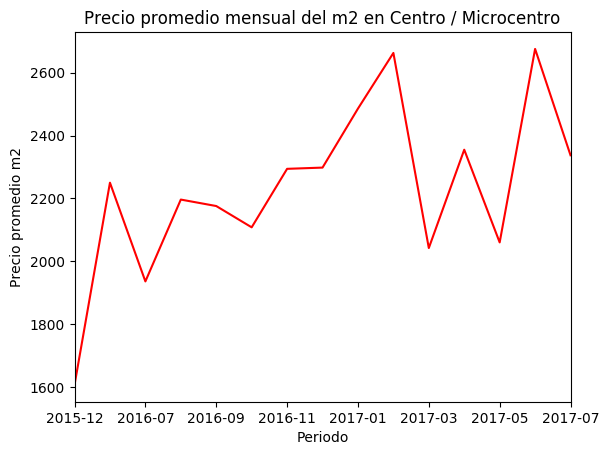

In [41]:
grafCentro = centroEnMesesGrouped['price_usd_per_m2']['mean'].plot(kind='line', color='r', title='Precio promedio mensual del m2 en Centro / Microcentro')
grafCentro.set_xlabel("Periodo")
grafCentro.set_ylabel("Precio promedio m2")

## En este caso se ve un crecimiento del precio por metro cuadrado a lo largo de los años
### Particularmente se observa un comienzo de crecimiento mayor a partir de Noviembre de 2016, lo que nada tiene que ver con que sea una zona centrica, sino que tiene que ver con el anuncio de la obra del MetroBus del Bajo (https://www.clarin.com/ciudades/arranca-nuevo-metrobus-recorrera-porteno_0_ryVbtfUxl.html) acompañado tambien por la obra del Paseo del bajo (http://www.lanacion.com.ar/1975181-que-es-el-paseo-del-bajo-la-obra-que-macri-inauguro-hoy-en-puerto-madero)

# Continuando con Nuñez

In [43]:
nuniez = CABAPorBarrioYAnioNoIndex.loc[CABAPorBarrioYAnioNoIndex.place_name.str.contains("Nuñez"), :]
nuniez

,place_name,year,price_usd_per_m2
63,Nuñez,2015,2394.176241
64,Nuñez,2016,3134.681434
65,Nuñez,2017,3148.846493


### En este caso podemos ver un crecimiento fuerte de 2015 a 2016. Estudiemos que paso en este periodo:

In [53]:
nuniezEnMeses = dataCapGbaSupmayor5.dropna(subset=['created_on', 'place_name'])
nuniezEnMeses = nuniezEnMeses.loc[nuniezEnMeses.place_name.str.contains("Nuñez"), ["created_on", "price_usd_per_m2", "lat", "lon", "description"]]
nuniezEnMeses.loc[:, "yearmonth"] = nuniezEnMeses.apply(lambda x: x["created_on"].partition("-")[0] + "-" + (x["created_on"].partition("-")[2]).partition("-")[0], axis = 1)
nuniezEnMeses = nuniezEnMeses.loc[nuniezEnMeses['yearmonth'] > '2015-04', :]
nuniezEnMeses = nuniezEnMeses.loc[nuniezEnMeses['yearmonth'] < '2016-05', :]
nuniezEnMesesGrouped = nuniezEnMeses.loc[:, ["yearmonth", "price_usd_per_m2"]].groupby('yearmonth').agg([np.mean, np.size])
nuniezEnMesesGrouped = nuniezEnMesesGrouped.loc[nuniezEnMesesGrouped['price_usd_per_m2']['size'] > 3, :]
nuniezEnMesesGrouped

price_usd_per_m2      
                      mean  size
yearmonth                       
2015-05        2265.820284   4.0
2015-06        1964.064271  15.0
2015-10        2418.796837   7.0
2016-01        2476.803741   5.0

### No hay cantidad de datos suficientes como para realizar un analisis